<img align="right" width="400" src="https://www.fhnw.ch/de/++theme++web16theme/assets/media/img/fachhochschule-nordwestschweiz-fhnw-logo.svg" alt="FHNW Logo">


# Base Model

by Fabian Märki

## Summary
The aim of this notebook is to train a *Base Model* using TF-IDF and a standard ML classifier with default hyperparameters. This builds a *base line* upon which more advanced models (i.e. deep learning ones) should show better performance in order to be considered. Additionally, it also investigate the how much individual features (i.e. words) contribute to the class assignment (feature importance) in order to get an idea if the classifier makes *reasonable* decisions.

<a href="https://colab.research.google.com/github/markif/2021_HS_DAS_NLP_Notebooks/blob/master/02_c_Base_Model.ipynb">
  <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
!pip install 'fhnw-nlp-utils>=0.1.3'

from fhnw.nlp.utils.storage import download
from fhnw.nlp.utils.storage import load_dataframe

import pandas as pd
import numpy as np

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
%%time
download("https://drive.google.com/uc?id=19AFeVnOfX8WXU4_3rM7OFoNTWWog_sb_", "data/german_doctor_reviews_tokenized.parq")
data = load_dataframe("data/german_doctor_reviews_tokenized.parq")
data.shape

CPU times: user 7.74 s, sys: 1.55 s, total: 9.29 s
Wall time: 5.13 s


(350087, 10)

In [3]:
data.head(3)

,text_original,rating,text,label,sentiment,token_clean,text_clean,token_lemma,token_stem,token_clean_stopwords
0,Ich bin franzose und bin seit ein paar Wochen ...,2.0,Ich bin franzose und bin seit ein paar Wochen ...,positive,1,"[ich, bin, franzose, und, bin, seit, ein, paar...",ich bin franzose und bin seit ein paar wochen ...,"[franzose, seit, paar, wochen, muenchen, zahn,...","[franzos, seit, paar, woch, muench, ., zahn, s...","[franzose, seit, paar, wochen, muenchen, ., za..."
1,Dieser Arzt ist das unmöglichste was mir in me...,6.0,Dieser Arzt ist das unmöglichste was mir in me...,negative,-1,"[dieser, arzt, ist, das, unmöglichste, was, mi...",dieser arzt ist das unmöglichste was mir in me...,"[arzt, unmöglichste, leben, je, begegnen, unfr...","[arzt, unmog, leb, je, begegnet, unfreund, ,, ...","[arzt, unmöglichste, leben, je, begegnet, unfr..."
2,Hatte akute Beschwerden am Rücken. Herr Magura...,1.0,Hatte akute Beschwerden am Rücken. Herr Magura...,positive,1,"[hatte, akute, beschwerden, am, rücken, ., her...",hatte akute beschwerden am rücken . herr magur...,"[akut, beschwerden, rücken, magura, erste, arz...","[akut, beschwerd, ruck, ., magura, erst, arzt,...","[akute, beschwerden, rücken, ., magura, erste,..."


In [4]:
# remove all neutral sentimens
data = data.loc[(data["label"] != "neutral")]
data.shape

(331187, 10)

Prepare the data (train/test split).Define *random_state* to have the same splits among different runs.

In [5]:
from sklearn.model_selection import train_test_split

# ensure we retain the class weights by using stratify
data_train, data_test = train_test_split(data, shuffle=True, random_state=42, stratify=data["label"])

In [6]:
X_train, y_train = data_train["token_lemma"], data_train["label"]
X_test, y_test = data_test["token_lemma"], data_test["label"]

Check if dataset is unbalanced. 

In [7]:
val_counts = data["label"].value_counts().sort_index()
val_counts

negative     33022
positive    298165
Name: label, dtype: int64

negative    0.099708
positive    0.900292
Name: label, dtype: float64


<AxesSubplot:>

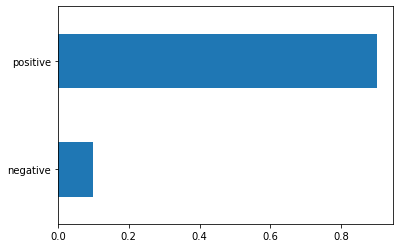

In [8]:
val_counts = val_counts / np.sum(val_counts)
print(val_counts)
val_counts.plot(kind='barh')

It seems the classes are quite unbalanced. 

Models often havd difficluties to predict the minor class (in our case, a model that simply predicts the major class already has an accurracy of 90 percent). Methods to deal with unbalanced classes are over- and under-sampling, weighing of classes, data augmentation etc. It turnes out that the classifier works quite good already the minority class already has a lot of observations (even though there are still some improvements possible as we will see later).

### Base Model

All default values without hyperparameter optimization.

In [9]:
%%time

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline

pipe = Pipeline([
         ("vec", CountVectorizer(tokenizer=lambda x: x,preprocessor=lambda x: x, stop_words=None)),
         ('tfidf', TfidfTransformer()),
         ("clf", SGDClassifier())
        ])
pipe.fit(X_train, y_train)

CPU times: user 4.05 s, sys: 94.9 ms, total: 4.15 s
Wall time: 4.16 s


Pipeline(steps=[('vec',
                 CountVectorizer(preprocessor=<function <lambda> at 0x7f18bab90d08>,
                                 tokenizer=<function <lambda> at 0x7f18bc625c80>)),
                ('tfidf', TfidfTransformer()), ('clf', SGDClassifier())])

In [10]:
y_train_pred = pipe.predict(X_train)
y_test_pred = pipe.predict(X_test)

In [11]:
from sklearn.metrics import classification_report

report = classification_report(y_train, y_train_pred)
print("Train:")
print(report)
report = classification_report(y_test, y_test_pred)
print("Test:")
print(report)

Train:
              precision    recall  f1-score   support

    negative       0.91      0.68      0.78     24766
    positive       0.97      0.99      0.98    223624

    accuracy                           0.96    248390
   macro avg       0.94      0.84      0.88    248390
weighted avg       0.96      0.96      0.96    248390

Test:
              precision    recall  f1-score   support

    negative       0.90      0.68      0.77      8256
    positive       0.97      0.99      0.98     74541

    accuracy                           0.96     82797
   macro avg       0.93      0.83      0.87     82797
weighted avg       0.96      0.96      0.96     82797



Set Population: 248390
Accuracy: 0.9615


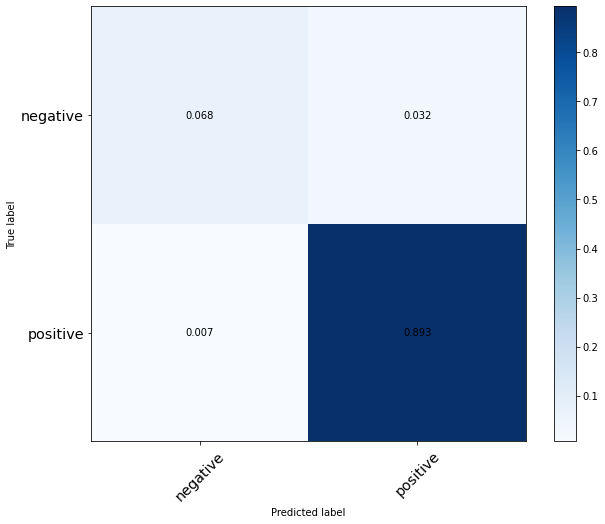

Set Population: 82797
Accuracy: 0.9601


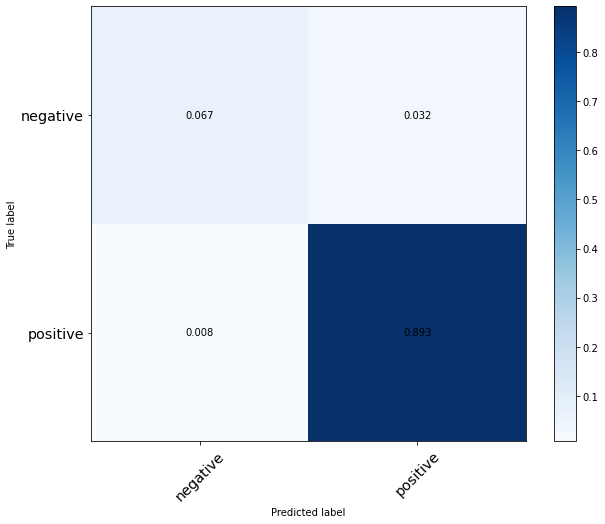

In [12]:
from fhnw.nlp.utils.ploting import plot_confusion_matrix

plot_confusion_matrix(y_train, y_train_pred)
plot_confusion_matrix(y_test, y_test_pred)

Check feature importance in order to get an idea if the class assignment builds on reasonable words. 

We can do this because SGDClassifier uses a LinearSVC by default. Recall that a linear SVM creates a hyperplane that uses support vectors to maximise the distance between the two classes. The weights obtained from svm.coef_ represent the vector coordinates which are orthogonal to the hyperplane and their direction indicates the predicted class. The absolute size of the coefficients in relation to each other can then be used to determine feature importance.

See also https://aneesha.medium.com/visualising-top-features-in-linear-svm-with-scikit-learn-and-matplotlib-3454ab18a14d

In [13]:
 def plot_feature_importance(classifier, feature_names, top_features=20):
    """Plot the feature importance of the top n features of a LinearSVC

    Parameters
    ----------
    classifier : LinearSVC
        The classifier
    feature_names : iterable
        The name of the features
    top_features : int
        The top n features to plog
    """
      
    import matplotlib.pyplot as plt
    
    coefs = classifier.coef_
    n_coefs = len(coefs)
    
    for i in range(n_coefs):
        label = classifier.classes_[i] + ("" if n_coefs >= len(classifier.classes_) else "/"+classifier.classes_[i + 1])
        coef = coefs[i,]
    
        top_positive_coefficients = np.argsort(coef)[-top_features:]
        top_negative_coefficients = np.argsort(coef)[:top_features]
        top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
 
        # create plot
        plt.figure(figsize=(15, 5))
        colors = ["red" if c < 0 else "green" for c in coef[top_coefficients]]
        plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
        feature_names = np.array(feature_names)
        plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha="right")
        plt.title(label)
        plt.show()

In [14]:
vectorizer = pipe.named_steps["vec"]
# only works since SGDClassifier uses LinearSVC by default
classifier = pipe.named_steps["clf"]

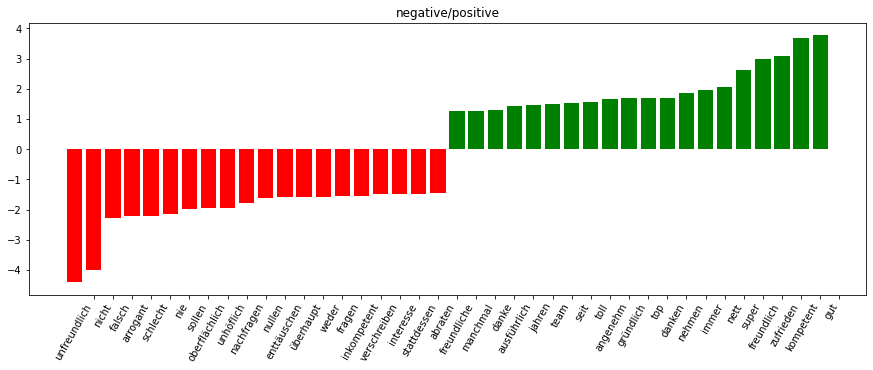

In [15]:
plot_feature_importance(classifier, vectorizer.get_feature_names())

Get an impression on texts with wrong prediction.

In [16]:
pd.set_option('display.max_colwidth', None)

data_train["prediction"] = y_train_pred

data_train[data_train["label"] != data_train["prediction"]][["text", "label", "prediction"]]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,text,label,prediction
2943,"Meine fast jährige Mutter kam zur Nachsorge nach einer gerichteten Oberschenkelfraktur zu Herrn Dr. Schallehn. Bei der Röntgenkontrolle Wochen nach der OP wurde ihr gesagt, dass sie nun voll belasten dürfe. Nach weiteren Wochen erfolgt eine weitere Röntgenkontrolle es sei alles in Ordnung. Eine Woche später bricht die implantierte Platte. Bei der ernauten OP stellt sich heraus, dass die Oberschenkelknochen nie verheilt war.",negative,positive
85355,"Den negativen Bewertungen muß ich mich anschließen. Während das Team der Schwestern freundlich ist, wirkt die Ärztin reserviert und abweisend. Fragen beantwortet sie nur widerwillig oder verweist darauf, daß sie keine Zeit habe. Ein Vertrauensverhältnis, welches zwischen Arzt und Patient bestehen sollte, läßt sich so nicht herstellen.",negative,positive
192073,"Habe mir hier die Weisheitszähne raus nehmen lassen. Ich hatte vorher total Panik weshalb ich mich für eine Vollnarkose entschieden hatte. Es wurden alle auf einmal entfernt. Tage nach der OP konnte ich wieder normal essen. Tage nach der OP war ich auf einem Konzert. Es ist kaum angeschwollen und IBU hat vollkommen gereicht. Nach Tagen heute wurden mir die Fäden gezogen inkl. Drainagen. Nach min war ich wieder raus und es tat überhaupt nicht weh. Es war eher ein angenehmes Gefühl als die Fäden gezogen wurden. Am ersten Tag nach der OP Samstag wurde ich von Dr. Hilden angerufen und gefragt wie es mir geht er sagte ich solle mich behandeln wie ein rohes ei Und am . oder . Tag nach der OP wurde ich von einer Schwester angerufen die noch mal gefragt hat wie es mir geht. Sehr fürsorglich! Alles in allem nur zu empfehlen. Bei niemandem mit dem ich gesprochen habe war es so einfach wie bei mir! Wäre ich doch nur nicht die letzte gewesen, dann hätten auch meine Freunde davon profitieren können",positive,negative
253925,"vorher telefonisch erfragt wann ich am besten vorbei kommen soll. Akuten Beschwerden am nächsten Tag pünktlichst Vorort an der Praxis erschienen. Wartezeit eingeplant. ohne Termin, weil krank jedes kommen und gehen der Patienten mitbekommen. nach höflichen erfragen der noch kommenden Wartezeit, gesagt bekommen das der Arzt entscheidet wann wer rein kommt und nochmal gesagt bekommen, dass man keinen Termin hätte. unbehandelt und krank wieder gegangen.",negative,positive
273247,"Herr Nagel ist ein guter Arzt, wenn man dringend einen Krankenschein benötigt. Wenn man ein etwas komplexeres Krankheitsbild hat, versagt er leider völlig. Auf eine Überweisung zum HNO von ihm musste ich mehrere Monate warten. Im Endeffekt war das Krankheitsbild so chronifiziert, dass ich eine stationäre OP brauchte. Ich kann Herrn Nagel leider nicht empfehlen.",negative,positive
...,...,...,...
281901,"Ich ging zu Dr. Fuchs um meinen Tetanus Schutz auf Grund einer Fußverletzung aufzufrischen! Alles wurde besprochen und wir entschieden uns für eine Tetanus diphtherie komobi Impfung. Ich habe ausdrücklich klar gemacht das ich nicht mehr möchte, der Dr. Stimmte zu um mir dann doch hinterrücks eine andere mehrfach Impfung zu geben! Ich habe noch nie so etwas erlebt! Bin zutiefst schockiert und kann jeden nur warnen zu diesem Arzt zu gehen.",negative,positive
116945,Eltern bekommen auch eine Krankschreibung an der Rezeption ohne das der Arzt das Kind gesehen hat. Diagnosen werden von den Praxis Mitarbeiterinnen am Telefon gestellt deshalb sind die Wartezeiten sehr kurz und Kleinkinder werden bei Fieber erst nach tagen richtig untersucht weil man der Auffassung ist es könnte sich um ein tage fieber handeln,negative,positive
217999,"Aufgrund eines freien Gelenkkörpers im Knie, der mir seit Monaten Beschwerden gemacht hat, habe ich Herrn Dr. König aufgesucht, um eine Arthroskopie durchführen zu lassen. Herr Dr. König hat das abgelehnt, da im Knie bereits Arthrose sei! Ich habe dann einen anderen Arzt gefunden, der mich innerhalb kürzester Zeit operiert hat. Dadurch kann ich jetzt endlich wieder beschwerdefrei laufen.",nega